<h3> Подключаем библиотеки

In [30]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.datasets import AirPassengersDataset
from darts.metrics import mae, mse, rmse, smape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

<h3> Очищаем данные

In [16]:
def clean_data(train_path: str, test_path: str, additional_dir: str):

    # Загрузка данных
    train = pd.read_excel(train_path, parse_dates=['dt'], engine='openpyxl')
    test_main = pd.read_excel(test_path, parse_dates=['dt'], engine='openpyxl')
    test_main['dt'] = pd.to_datetime(test_main['dt'])
    additional_files = list(Path(additional_dir).glob('*.xlsx'))
    
    # Загрузка и объединение всех данных
    all_dfs = [train]
    for file in additional_files:
        train_df = pd.read_excel(file, engine='openpyxl')
        train_df['dt'] = pd.to_datetime(train_df['dt'])
        all_dfs.append(train_df)
    
    # Объединение данных в один список
    combined = pd.concat(all_dfs, ignore_index=True)
    
    # Определяем начало недели (понедельник)
    combined['week_start'] = combined['dt'] - pd.to_timedelta(combined['dt'].dt.dayofweek, unit='D')
    
    # Агрегация по медиане для всех числовых колонок
    numeric_cols = combined.select_dtypes(include=['number']).columns.tolist()
    weekly_df = combined.groupby('week_start')[numeric_cols].median().reset_index()
    
    # Переименовываем колонку week_start в dt
    train_df = weekly_df.rename(columns={'week_start': 'dt'})

    train_df = train_df.replace('', np.nan)  # Заменяем пустые строки на NaN
    train_df = train_df.replace(0, np.nan)  # Заменяем 0 на NaN
    train_df = train_df.replace('0', np.nan) # Заменяем строковое "0" на NaN

    # Заполняем пропуски, который образовались из-за разрыва месячных данных на недели
    for col in train_df.columns:
        first_valid_index = train_df[col].first_valid_index()
        if first_valid_index is not None:
            non_nan_indices = train_df[col].dropna().index
            for index in non_nan_indices:
                fill_indices = range(index + 1, min(index + 1 + 3, len(train_df)))
                for i in fill_indices:
                    if pd.isna(train_df.loc[i, col]):
                        train_df.loc[i, col] = train_df.loc[index, col]
    
    threshold = 0.70 # 70% пропусков допустимо, больше - удаляем колонку
    for col in train_df.columns:
        if train_df[col].isnull().sum() / len(train_df) > threshold:
            train_df.drop(col, axis=1, inplace=True)  # Удаляем слишком пустой столбец в цикле

    # Заполняем пропуски методом соседних значений
    train_df = train_df.ffill().bfill()  # Применяем ffill, а затем bfill

    # Выбор признаков с помощью ANOVA F-value
    selector = SelectKBest(score_func=f_regression, k=17)  # Оставьте топ-20 признаков
    X_selected = selector.fit_transform(train_df.drop(['dt', 'price'], axis=1), train_df['price'])

    # Получение названий отобранных колонок
    selected_cols = train_df.drop(['dt', 'price'], axis=1).columns[selector.get_support()]
    print("Отобранные признаки:", selected_cols.tolist())

    # Обновление датафрейма
    train_df = train_df[['dt', 'price'] + selected_cols.tolist()]

    test_df = train_df[train_df['dt'] > pd.to_datetime('2022-08-29')]
    test_df = test_df[test_df['dt'] <= pd.to_datetime('2023-03-13')]
    train_df = train_df[train_df['dt'] <= pd.to_datetime('2022-08-29')]

    del test_df['price']

    # Возвращаем готовый датасет
    return train_df, test_df, test_main

train_df, test_df, test_main = clean_data(train_path='train.xlsx', test_path = 'test.xlsx', additional_dir='D:\Visual Studio Code\Intensive_Armatyra\data')
print(train_df.head()) # Выводим готовый датасет
train_df.to_excel('merged_data.xlsx', index=False, engine='openpyxl') # Сохраняем готовый датасет
# test_df.to_excel('test_df.xlsx', index=False, engine='openpyxl') # Сохраняем готовый датасет

<>:72: SyntaxWarning: invalid escape sequence '\V'
<>:72: SyntaxWarning: invalid escape sequence '\V'
C:\Users\slava\AppData\Local\Temp\ipykernel_1092\541691257.py:72: SyntaxWarning: invalid escape sequence '\V'
  train_df, test_df, test_main = clean_data(train_path='train.xlsx', test_path = 'test.xlsx', additional_dir='D:\Visual Studio Code\Intensive_Armatyra\data')


Отобранные признаки: ['Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т', 'Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС', 'Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС', 'Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС', 'Чугун_CFR Италия, $/т', 'ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т', 'Лом_3А, FOB РФ Черное море, $/т', 'Лом_HMS 1/2 80:20, CFR ЮВА, $/т', 'Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС', 'Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС', 'Чугун_FOB Россия Черное море, $/т', 'Чугун_Россия, FCA руб./т, без НДС', 'ГБЖ_CFR Италия, $/т', 'Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС', 'Лом_HMS 1/2 80:20, CFR Турция, $/т', 'Чугун_CFR Китай, $/т', 'Чугун_CFR Турция, $/т']
          dt    price  Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т  \
0 2015-01-05  32900.0                                     228.0   
1 2015-01-12  32500.0                                     228.0   
2 2015-01-19  32000.0                                

In [17]:
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = train_df.select_dtypes(include=['object']).columns
boolean_columns = train_df.select_dtypes(include=['bool']).columns

print("")
print(f"Числовые колонки в готовом датасете: {len(numeric_columns)}")
print(f"Категориальные колонки в готовом датасете: {len(categorical_columns)}")
print(f"Булевые колонки в готовом датасете: {len(boolean_columns)}")


Числовые колонки в готовом датасете: 18
Категориальные колонки в готовом датасете: 0
Булевые колонки в готовом датасете: 0


<Axes: >

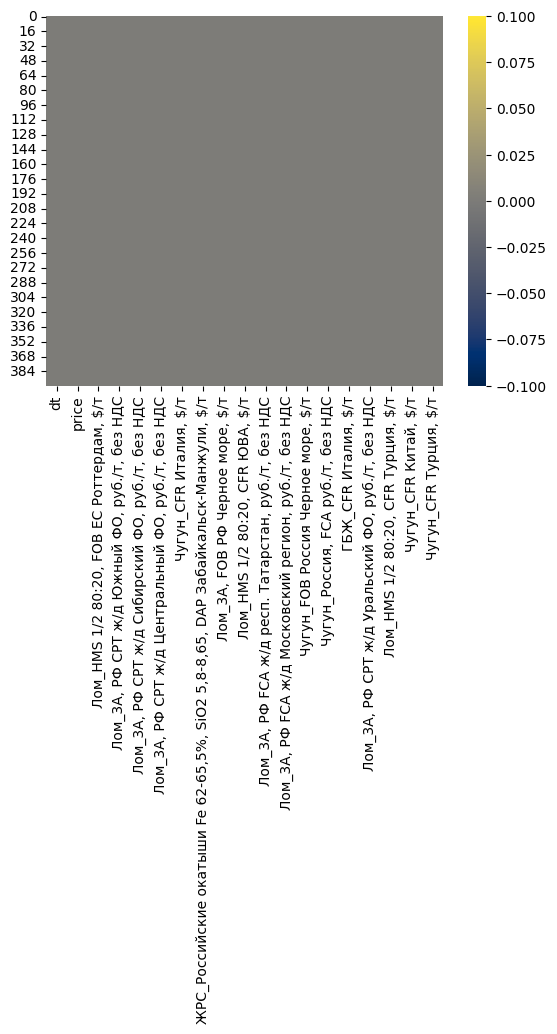

In [18]:
sns.heatmap(train_df.isnull(), cmap='cividis')

20:40:46 - cmdstanpy - INFO - Chain [1] start processing
20:40:46 - cmdstanpy - INFO - Chain [1] done processing


            ds  predicted_price
400 2022-09-05          45600.0
401 2022-09-12          42100.0
402 2022-09-19          39900.0
403 2022-09-26          39600.0
404 2022-10-03          42700.0
405 2022-10-10          42200.0
406 2022-10-17          41200.0
407 2022-10-24          39200.0
408 2022-10-31          38600.0
409 2022-11-07          36100.0
410 2022-11-14          36300.0
411 2022-11-21          33200.0
412 2022-11-28          33200.0
413 2022-12-05          33500.0
414 2022-12-12          35900.0
415 2022-12-19          37300.0
416 2022-12-26          37500.0
417 2023-01-02          38700.0
418 2023-01-09          39900.0
419 2023-01-16          41200.0
420 2023-01-23          41700.0
421 2023-01-30          40300.0
422 2023-02-06          41600.0
423 2023-02-13          41400.0
424 2023-02-20          43000.0
425 2023-02-27          44300.0
426 2023-03-06          46600.0
427 2023-03-13          48200.0
MAE: 4214.29
R2-score: -0.66


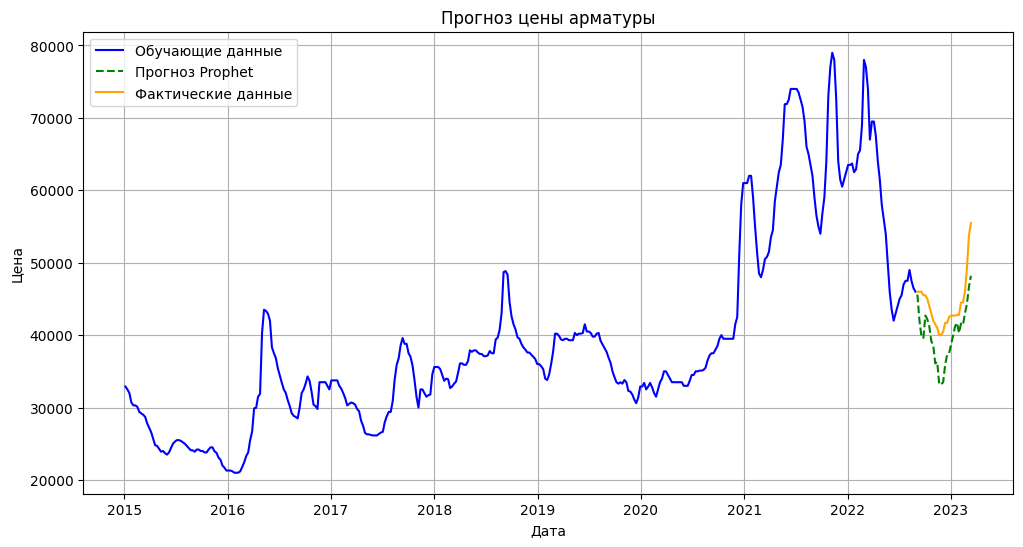

In [21]:
# Предположим, у вас есть:
# train_df - исторические данные с ценами
# test_df - датафрейм для прогноза с дополнительными признаками

# 1. Подготовка обучающих данных
train_df = train_df.rename(columns={'dt': 'ds', 'price': 'y'})
train_df['ds'] = pd.to_datetime(train_df['ds'])

# Добавляем ограничения для логистического роста
train_df['cap'] = train_df['y'].max() * 1.5  # Максимальный предел (на 50% выше исторического максимума)
train_df['floor'] = 0  # Минимальный предел

# 2. Инициализация модели с настройками
model = Prophet(
    weekly_seasonality=True,
    changepoint_prior_scale=0.01,  # Снижаем чувствительность к выбросам
    growth='logistic',  # Ограничиваем рост
    # seasonality_mode='multiplicative'  # Для нелинейной сезонности
)

# Добавляем регрессоры явно (убедитесь, что они есть в test_df)
required_regressors = [col for col in train_df.columns if col not in ['ds', 'y', 'cap', 'floor']]
for regressor in required_regressors:
    model.add_regressor(regressor)

# 3. Подготовка тестовых данных
test_df = test_df.rename(columns={'dt': 'ds'})
test_df['ds'] = pd.to_datetime(test_df['ds'])

# Добавляем cap и floor в test_df
test_df['cap'] = train_df['cap'].iloc[0]  # Используем тот же предел, что и в обучающих данных
test_df['floor'] = 0

# 4. Обучение модели
model.fit(train_df)

# 5. Прогнозирование
forecast = model.predict(test_df)

# 6. Добавляем прогнозы в test_df
test_df['predicted_price'] = forecast['yhat'].values
test_df['predicted_price'] = round(test_df['predicted_price'], -2)
print(test_df[['ds', 'predicted_price']])

# Вычисление метрик
y_true = test_main['price']
y_pred = test_df['predicted_price']

print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
print(f"R2-score: {r2_score(y_true, y_pred):.2f}")


# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'], train_df['y'], label='Обучающие данные', color='blue')
plt.plot(test_df['ds'], test_df['predicted_price'], label='Прогноз Prophet', color='green', linestyle='--')
plt.plot(test_main['dt'], test_main['price'], label='Фактические данные', color='orange')

plt.title('Прогноз цены арматуры')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

test_df.to_excel('predicted_price.xlsx', index=False, engine='openpyxl') # Сохраняем готовый датасет

In [ ]:
# 1. Загрузка данных (пример с Air Passengers)
series = AirPassengersDataset().load()

# 2. Преобразование в Pandas DataFrame для демонстрации работы с внешними данными
df = series.pd_dataframe().reset_index()
df.columns = ['Month', 'Passengers']

# 3. Создание TimeSeries из DataFrame
series = TimeSeries.from_dataframe(df, 'Month', 'Passengers')

# 4. Разделение на train/test (последние 24 месяца для теста)
train, test = series.split_before(pd.Timestamp('19590101'))

# 5. Нормализация данных
scaler = Scaler()  # Min-Max scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# 6. Создание модели
model = NBEATSModel(
    input_chunk_length=24,  # Окно истории для анализа
    output_chunk_length=12,  # Длина прогноза за один шаг
    num_stacks=5,           # Количество стеков
    num_blocks=3,           # Блоки в каждом стеке
    num_layers=4,           # Слои в каждом блоке
    generic_architecture=False,  # Интерпретируемый режим
    n_epochs=100,
    random_state=42
)

# 7. Обучение модели
model.fit(
    train_scaled,
    val_series=test_scaled,
    verbose=True
)

# 8. Прогнозирование на длину тестового набора
prediction_scaled = model.predict(n=len(test_scaled))

# 9. Обратное преобразование нормализации
prediction = scaler.inverse_transform(prediction_scaled)
test = scaler.inverse_transform(test_scaled)

# 10. Расчет метрик
metrics = {
    'MAE': mae(test, predicion),
    'MSE': mse(test, predicion),
    'RMSE': rmse(test, predicion),
    'sMAPE': smape(test, predicion)
}

print("\nМетрики качества:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# 11. Визуализация
plt.figure(figsize=(12, 6))
train.plot(label='Train')
test.plot(label='True')
prediction.plot(label='Forecast')
plt.title('Прогнозирование временного ряда с помощью N-BEATS')
plt.legend()
plt.grid(True)
plt.show()